In [24]:
import spacy
import matplotlib.pyplot as plt
import json
import requests
import pandas as pd
import os
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from io import BytesIO

nlp = spacy.load("en_core_web_sm")
nltk.download('stopwords')

def load_jsons_from_directory(directory):
    json_files = [f for f in os.listdir(directory) if f.endswith('.json')]
    json_data = {}
    for json_file in json_files:
        with open(os.path.join(directory, json_file), 'r') as file:
            data = json.load(file)
            incomplete_doi = os.path.splitext(json_file)[0]
            json_data[incomplete_doi] = data
    return json_data

def load_json(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)


def augment_questions_with_data(questions_data, all_data):
    for question_entry in questions_data:
        doi = question_entry['doi']
        if doi in all_data:
            question_entry['related_data'] = all_data[doi]
            question_entry['doi'] = all_data[doi]["DOI"][len("https://doi.org/"):]
    return questions_data

def save_json(data, file_path):
    with open(file_path, 'w', encoding='utf-8') as file:
        json.dump(data, file, ensure_ascii=False, indent=4)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/potatosalad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
with open("../data/all_questions_gpt_4.json", 'r') as file:
    data = json.load(file)

In [21]:
all_data = load_jsons_from_directory('../data/all_output')
print(len(all_data))

questions_data = load_json('../data/all_questions_gpt_4.json')

all_data = augment_questions_with_data(questions_data, all_data)

save_json(all_data, '../data/chem_mqa_dataset.json')

459


In [22]:
all_data[1]

{'Question_2': {'Context': 'The administration route of nanoparticles can significantly affect their behavior in vivo, particularly in terms of tissue absorption, metabolism, and elimination.',
  'Question': 'Which administration route for nanoparticles resulted in the highest and most targeted pulmonary uptake?',
  'A': 'Intravenous',
  'B': 'Intramuscular',
  'C': 'Intranasal',
  'D': 'Subcutaneous',
  'Answer': 'C',
  'Source': 'Positron emission tomography revealed that intranasal delivery resulted in the highest and most targeted pulmonary uptake, whereas intravenous administration led to accumulation mainly in the liver and spleen.'},
 'doi': '10.1186/s41181-023-00227-x',
 'related_data': {'Title': 'Real-time in vivo behaviour of PLGA nanoparticles across various administration routes',
  'Abstract': 'Nanoparticles exhibit distinct behaviours within the body, depending on their physicochemical properties and administration routes. In this study, the real-time in vivo behaviour of

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter
import re

# Set global font settings for the plots
plt.rcParams.update({
    'axes.labelsize': 18,  # Axis label size
    'axes.labelweight': 'bold',  # Axis label weight
    'xtick.labelsize': 18,  # X-axis tick label size
    'ytick.labelsize': 18,  # Y-axis tick label size
    'font.size': 18,  # General font size
    'font.weight': 'bold',  # General font weight
    'axes.titlesize': 20,  # Title size
    'axes.titleweight': 'bold',  # Title weight
})

# Extracting and separating the data into DataFrames
questions = []
related_data = []
for entry in all_data:
    for key, value in entry.items():
        if key.startswith('Question'):
            questions.append(value)
        elif key == 'related_data':
            related_data.append(value)

questions_df = pd.DataFrame(questions)
related_data_df = pd.DataFrame(related_data)

# 1. Distribution of Answer Choices
plt.figure(figsize=(10, 6))
sns.countplot(x=questions_df['Answer'], palette='Set2')
plt.title('Distribution of Answer Choices')
plt.xlabel('Answer')
plt.ylabel('Count')
plt.savefig('distribution_of_answer_choices.pdf', bbox_inches='tight')  # Save the figure to a PDF
plt.close()

# 2. Context Length Analysis
questions_df['Context_Length'] = questions_df['Context'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(questions_df['Context_Length'], kde=True, color='skyblue')
plt.title('Distribution of Context Lengths')
plt.xlabel('Number of Words in Context')
plt.ylabel('Frequency')
plt.savefig('context_length_analysis.pdf', bbox_inches='tight')  # Save the figure to a PDF
plt.close()

# 3. Keyword Frequency Analysis
all_keywords = related_data_df['Keywords'].sum()  # Flatten the list of lists
keyword_counts = Counter(all_keywords)
keywords_df = pd.DataFrame(keyword_counts.items(), columns=['Keyword', 'Frequency'])
keywords_df = keywords_df.sort_values(by='Frequency', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Keyword', data=keywords_df.head(10), palette='muted')
plt.title('Top 10 Most Frequent Keywords')
plt.xlabel('Frequency')
plt.ylabel('Keyword')
plt.savefig('keyword_frequency_analysis.pdf', bbox_inches='tight')  # Save the figure to a PDF
plt.close()

# 4. Author Analysis (Top 10 Most Common Authors excluding placeholders like 'et al')
all_authors = related_data_df['Authors'].sum()  # Flatten the list of lists

# Remove non-informative author names
excluded_authors = {'et al.', 'et al', 'author two', 'author three', 'author four', 'author five'}
filtered_authors = [author for author in all_authors if author.lower() not in excluded_authors]

# Count the frequency of the remaining authors
author_counts = Counter(filtered_authors)
authors_df = pd.DataFrame(author_counts.items(), columns=['Author', 'Frequency'])
authors_df = authors_df.sort_values(by='Frequency', ascending=False)

# Plotting the top 10 most frequent authors
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Author', data=authors_df.head(10), palette='coolwarm')
plt.title('Top 10 Most Frequent Authors (Excluding Non-Informative Names)')
plt.xlabel('Frequency')
plt.ylabel('Author')
plt.savefig('author_analysis.pdf', bbox_inches='tight')  # Save the figure to a PDF
plt.close()

# 5. University Analysis (Top 10 Most Common Universities excluding 'Materials Theory')
# Flatten the 'Institute of Origin' field if it's a list, otherwise, just use it directly
all_universities = [' '.join(x) if isinstance(x, list) else x for x in related_data_df['Institute of Origin']]

# Remove 'Materials Theory' from the list of universities
all_universities = [university for university in all_universities if 'Materials Theory' not in university]

# Count the frequency of each university
university_counts = Counter(all_universities)
universities_df = pd.DataFrame(university_counts.items(), columns=['University', 'Frequency'])
universities_df = universities_df.sort_values(by='Frequency', ascending=False)

# Plotting the top 10 most frequent universities
plt.figure(figsize=(12, 8))
sns.barplot(x='Frequency', y='University', data=universities_df.head(10), palette='coolwarm')
plt.title('Top 10 Most Frequent Universities (Excluding Materials Theory)')
plt.xlabel('Frequency')
plt.ylabel('University')
plt.savefig('university_analysis.pdf', bbox_inches='tight')  # Save the figure to a PDF
plt.close()

# 6. Extract and Count Country of Origin for Universities
def extract_country(institute):
    """
    Extracts the country from the Institute of Origin, assuming it often appears at the end of the string.
    """
    country_patterns = [
        r'South Korea', r'Korea', r'China', r'USA', r'United Kingdom', r'UK', r'Germany',
        r'France', r'Canada', r'Australia', r'Japan', r'India', r'Netherlands',
        r'Italy', r'Sweden', r'Spain', r'Brazil', r'Switzerland', r'Singapore'
    ]

    for pattern in country_patterns:
        if re.search(pattern, institute, re.IGNORECASE):
            return pattern

# Apply the function to extract countries
countries = [extract_country(institute) for institute in all_universities]

# Ensure the length of 'countries' matches the DataFrame length
if len(countries) == len(related_data_df):
    related_data_df['Country'] = countries
else:
    related_data_df['Country'] = pd.Series(countries[:len(related_data_df)])

# Count the frequency of publications per country
country_counts = related_data_df['Country'].value_counts()

# Plotting the number of publications per country
plt.figure(figsize=(12, 8))
sns.barplot(x=country_counts.values, y=country_counts.index, palette='viridis')
plt.title('Number of Publications per Country of Origin')
plt.xlabel('Number of Publications')
plt.ylabel('Country')
plt.savefig('country_of_origin_analysis.pdf', bbox_inches='tight')  # Save the figure to a PDF
plt.close()

# 7. Research Group Analysis (Top 10 Most Common Research Groups)
# Assuming 'Research Group' field exists or we use 'Institute of Origin' as a proxy for research groups
# If 'Research Group' is not separate, this code will use 'Institute of Origin'

all_research_groups = [' '.join(x) if isinstance(x, list) else x for x in related_data_df['Institute of Origin']]

# Count the frequency of each research group
research_group_counts = Counter(all_research_groups)
research_groups_df = pd.DataFrame(research_group_counts.items(), columns=['Research Group', 'Frequency'])
research_groups_df = research_groups_df.sort_values(by='Frequency', ascending=False)

# Plotting the top 10 most frequent research groups
plt.figure(figsize=(12, 8))
sns.barplot(x='Frequency', y='Research Group', data=research_groups_df.head(10), palette='viridis')
plt.title('Top 10 Most Frequent Research Groups')
plt.xlabel('Frequency')
plt.ylabel('Research Group')
plt.savefig('research_group_analysis.pdf', bbox_inches='tight')  # Save the figure to a PDF
plt.close()

# 8. Keyword Analysis (Top 10 Most Common Keywords)
# The 'Keywords' field is already a list of lists, so we aggregate and count as before

# Count the frequency of each keyword
keyword_counts = Counter(all_keywords)
keywords_df = pd.DataFrame(keyword_counts.items(), columns=['Keyword', 'Frequency'])
keywords_df = keywords_df.sort_values(by='Frequency', ascending=False)

# Plotting the top 10 most frequent keywords
plt.figure(figsize=(12, 8))
sns.barplot(x='Frequency', y='Keyword', data=keywords_df.head(10), palette='magma')
plt.title('Top 10 Most Frequent Keywords')
plt.xlabel('Frequency')
plt.ylabel('Keyword')
plt.savefig('keyword_analysis.pdf', bbox_inches='tight')  # Save the figure to a PDF
plt.close()


In [4]:
def fetch_year(doi):
    url = f"https://api.crossref.org/works/{doi}"
    try:
        response = requests.get(url)
        response.raise_for_status()
        json_data = response.json()
        year = json_data.get('message', {}).get('created', {}).get('date-parts', [[None]])[0][0]
        return year
    except requests.exceptions.RequestException as e:
        return np.nan
    except json.JSONDecodeError:
        return np.nan

file_path = '../data/chem_mqa_dataset.json'
questions_data = load_json(file_path)

for question_entry in questions_data:
    if 'doi' in question_entry:
        doi = question_entry['doi']
        year = fetch_year(doi)
        print(year)
        year = 'NaN' if pd.isna(year) else str(year)
        print("="*25)
        question_entry['year'] = year

save_json(questions_data, file_path)

2024
2024
2024
2024
2024
2024
2024
2024
2024
2024
2024
2024
2024
2024
2024
2024
2024
2024
2024
2024
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2022
2022
2022
2022
2022
2022
2022
2022
2022
2022
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
2023
2023
2023
2023
2023
2023
2023
2023
2023
2023
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
2021
2021
2021
2021
2021
2021
2021
2021
2021
2021
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2023
2023
2023
2023
2023
2023
2023
2023
2023
2023
2024
2024
2024
2024
2024
2024
2024
2024
2024
2024
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
2023
2023
2023
2023
2023
2023
2023
2023
2023
2023
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


In [2]:
data = load_json('../data/chem_mqa_dataset.json')
data[0]

{'Question_1': {'Context': 'Nanoparticles can be engineered to exhibit certain behaviors within biological systems, which can be influenced by their size, shape, surface charge, and chemical modifications.',
  'Question': 'What is the effect of nanoparticle size on their uptake by phagocytic cells?',
  'A': 'Size has no effect on uptake by phagocytic cells',
  'B': 'Larger nanoparticles are more readily engulfed by phagocytic cells',
  'C': 'Smaller nanoparticles are more readily engulfed by phagocytic cells',
  'D': 'Only nanoparticles of medium size are engulfed by phagocytic cells',
  'Answer': 'B',
  'Source': 'Our results of internalisation experiments involving three submicron-sized nanoparticles and RAW264.7 murine macrophage cells suggested that the uptake of nanoparticles by phagocytic cells is size-dependent. Recent studies have reported similar findings of internalisation experiments involving macrophage cell lines and PLGA nanoparticles, emphasising that larger nanoparticle

In [3]:
def filter(data, topic, start_year, end_year):
    # matcher = PhraseMatcher(nlp.vocab)
    # pattern = nlp(topic)
    # matcher.add("TOPIC", [pattern])
    filtered_questions = []

    for item in data:
        item_year = item.get('year', None)

        if item_year and start_year <= item_year <= end_year:
            text_to_search = ""
            if "Question_1" in item:
                question = item["Question_1"]
                text_to_search += f"{question['Context']} {question['Question']} {question.get('Source', '')}"

            if "related_data" in item:
                related_data = item["related_data"]
                text_to_search += f" {related_data.get('Title', '')} {related_data.get('Abstract', '')} {' '.join(related_data.get('Keywords', []))}"
                text_to_search += f" {related_data.get('Methods', '')} {related_data.get('Results', '')} {related_data.get('Experiment details', '')}"

            if any(word.lower() in text_to_search.lower() for word in topic):
                filtered_questions.append(item)

    return filtered_questions

topic = [
    "catalysis", "biocatalytic", "biocatalysis", "catalyst", "enzyme", "catalytic", "catalyze", "catalyzed", "catalyzing", "catalytic activity", "chemical reaction", "reaction rate", "reaction mechanism", "heterogeneous catalysis", "homogeneous catalysis", "metal catalyst", "organocatalysis", "enzyme catalysis", "transition metal catalyst", "acid catalysis", "activation energy", "kinetics", "substrate", "product", "selectivity", "activity", "chemical transformation", "enzyme kinetics", "transition state", "reaction intermediate", "enzymatic", "photochemical", "catalytic cycle", "chemical bond activation", "hydrogenation", "oxidation", "reduction", "dehydrogenation", "hydrogenolysis", "isomerization", "polymerization", "decarboxylation", "hydrolysis", "esterification", "acylation", "dehalogenation", "hydrogen transfer", "carbonylation", "metathesis", "carbon-carbon bond formation", "hydrogen bond activation", "regioselectivity", "stereoselectivity", "enantioselectivity", "asymmetric catalysis", "enantioenrichment", "enantioenriched", "enantioselective", "enantioselectivity", "enantiospecific", "enantiospecificity", "enantioseparation", "enantioenrichment", "enantioselective synthesis", "enantioselective reaction", "enantioselective catalyst", "enantioselective transformation", "enantioselective addition", "enantioselective hydrolysis", "enantioselective reduction", "enantioselective oxidation", "enantioselective desymmetrization", "enantioselective esterification", "enantioselective amidation", "enantioselective alkylation", "enantioselective ring opening", "enantioselective ring closing", "enantioselective cyclization", "enantioselective allylation", "enantioselective allylic substitution"
]

start_year = 2024
end_year = 2024

filtered = filter(data, topic, start_year, end_year)

In [4]:
print(len(filtered))

350


In [5]:
print(filtered[0])

{'Question_11': {'Context': 'Alkaline hydrogen peroxide (AHP) treatment is used to enhance the digestibility of lignocellulosic biomass by removing lignin and other components that limit enzyme access to cellulose.', 'Question': 'What is the primary purpose of using alkaline hydrogen peroxide (AHP) treatment on lignocellulosic biomass?', 'A': 'To increase its weight', 'B': 'To enhance its digestibility', 'C': 'To change its color', 'D': 'To reduce its energy content', 'Answer': 'B', 'Source': 'The optimization of AHP treatment is a key step to minimize the cost of treatment without increasing both polyphenols content and lipid oxidation. In this regard, AHP treatment of EOP was investigated using the response surface methodology RSM in which sodium hydroxide (NaOH) varied between 1% (w/v) to 6% (w/v) and hydrogen peroxide (H2O2) varied between 1% (w/v) and 4% (w/v).'}, 'doi': '10.1186/s40538-024-00533-9', 'related_data': {'Title': 'Effect of Alkaline Hydrogen Peroxide Pretreatment on I

In [10]:
print(filtered[:1])

[{'Question_11': {'Context': 'Alkaline hydrogen peroxide (AHP) treatment is used to enhance the digestibility of lignocellulosic biomass by removing lignin and other components that limit enzyme access to cellulose.', 'Question': 'What is the primary purpose of using alkaline hydrogen peroxide (AHP) treatment on lignocellulosic biomass?', 'A': 'To increase its weight', 'B': 'To enhance its digestibility', 'C': 'To change its color', 'D': 'To reduce its energy content', 'Answer': 'B', 'Source': 'The optimization of AHP treatment is a key step to minimize the cost of treatment without increasing both polyphenols content and lipid oxidation. In this regard, AHP treatment of EOP was investigated using the response surface methodology RSM in which sodium hydroxide (NaOH) varied between 1% (w/v) to 6% (w/v) and hydrogen peroxide (H2O2) varied between 1% (w/v) and 4% (w/v).'}, 'doi': '10.1186/s40538-024-00533-9', 'related_data': {'Title': 'Effect of Alkaline Hydrogen Peroxide Pretreatment on 

<?xml version="1.0" encoding="utf-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
  "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<svg xmlns:xlink="http://www.w3.org/1999/xlink" width="720pt" height="360pt" viewBox="0 0 720 360" xmlns="http://www.w3.org/2000/svg" version="1.1">
 <metadata>
  <rdf:RDF xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:cc="http://creativecommons.org/ns#" xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#">
   <cc:Work>
    <dc:type rdf:resource="http://purl.org/dc/dcmitype/StillImage"/>
    <dc:date>2024-05-06T16:48:13.991414</dc:date>
    <dc:format>image/svg+xml</dc:format>
    <dc:creator>
     <cc:Agent>
      <dc:title>Matplotlib v3.7.2, https://matplotlib.org/</dc:title>
     </cc:Agent>
    </dc:creator>
   </cc:Work>
  </rdf:RDF>
 </metadata>
 <defs>
  <style type="text/css">*{stroke-linejoin: round; stroke-linecap: butt}</style>
 </defs>
 <g id="figure_1">
  <g id="patch_1">
   <path d="M 0 360 
L 720 360 
L 720 0 
L

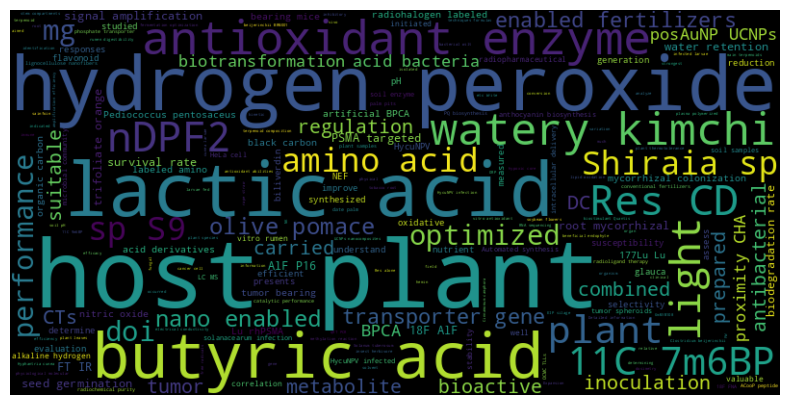

In [6]:
def collect_text(data):
    text_data = []
    for item in data:
        text = ""
        if "Question_" in item:
            question_data = item["Question_"]
            context = question_data.get('Context', '')
            question = question_data.get('Question', '')
            answer = question_data.get('Answer', '')
            source = question_data.get('Source', '')
            text += f"{context} {question} {answer} {source} "
        
        if "related_data" in item:
            related_data = item["related_data"]
            keywords = ' '.join(related_data.get('Keywords', []))
            abstract = related_data.get('Abstract', '')
            methods = related_data.get('Methods', '')
            results = related_data.get('Results', '')
            exp_details = related_data.get('Experiment details', '')
            text += f"{keywords} {abstract} {methods} {results} {exp_details} "
        
        text_data.append(text.strip())
    return text_data

def generate_word_cloud(documents):
    # ----------- Not using right now -----------------------------------------
    # Initialize TF-IDF Vectorizer to identify common words
    vectorizer = TfidfVectorizer(stop_words='english', max_df=0.3)
    _ = vectorizer.fit_transform(documents)
    
    # Retrieve the words that were ignored because they're too common
    common_terms = set(vectorizer.stop_words_)
    # ----------- Not using right now -----------------------------------------

    nltk_stopwords = set(stopwords.words('english'))
    
    manual_remove = [
        "certain", "involved", "response", "surface", "particular", "study", "show", "results", "found", "result", "used", "using", "studies", "provide", "provide", "discuss", "investigate", "investigation", "provide", "demonstrate", "evaluate", "evaluate", "propose", "novel", "investigated", "found", "proposed", "discussed", "demonstrated", "reported", "shown", "research", "investigate", "investigating", "evaluated", "evaluate", "proposed", "proposes", "novel", "investigated", "demonstrated", "reported", "showed", "demonstrated", "investigate", "investigating", "proposed", "proposes", "novel", "investigated", "reported", "shown", "discuss", "discusses", "provide", "provides", "demonstrate", "demonstrates", "evaluate", "evaluates", "investigate", "investigates", "propose", "proposes", "novel", "novels", "investigated", "investigations", "demonstrated", "demonstrates", "reported", "reports", "shown", "shows", "discussing", "proposing", "investigated", "demonstrated", "reported", "showed", "discussed", "proposed", "novel", "investigated", "demonstrated", "reported", "shown", "discuss", "investigate", "evaluate", "propose", "novel", "research", "role", "including", "known", "context", "content", "use", "important", "different", "production", "effect", "affect", "method", "application", "compound", "structure", "activity", "form", "also", "role", "including", "known", "context", "content", "use", "important", "different", "production", "effect", "affect", "method", "application", "compound", "structure", "activity", "form", "also", "a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z", "process activities", "presence",
        "function", "involve", "compared", "component", "level", "increased", "highest", "methods", "higher", "influence", "identified", "formation", "refer", "due", "product", "analysis", "technique", "concentration", "within", "substance", "purpose", "various", "chemical", "properties", "play", "specific", "increase", "compounds", "process", "involves", "include", "seconday", "dose", "time", "indicating", "lower", "observed", "target", "respectively", "value", "material",
        "et al", "factor", "potential", "following", "produce", "system", "measure", "uptake", "term", "associated", "total", "change", "low", "ga", "one", "two", "three", "produced", "significantly", "components", "development", "characterized",
        "often", "expression", "effective", "mechanism", "growth", "interaction", "yield", "detection", "ability", "levels", "amount", "essential", "enhance", "chemistry", "part", "activities", "control", "model", "imaging", "crucial",
        "heme", "ratio", "changes", "commonly", "primary", "significant", "processes", "refers", "size", "stress", "defense", "induce", "materials", "therapeutic", "group", "high", "assay", "distribution", "treatment", "environmental", "like",
        "element", "molecule", "condition", "validation", "parameter", "substances", "however", "host plant", "heat", "resistance", "agent", "disease", "non", "may", "health", "parameters", "conducted", "experiment", "focused", "effects", "review", "importance", "work", "developed", "temperature", "analyzed", "employed", "applications", "performed", "day", "conditions", "present", "biological", "red", "impact", "days", "secondary"
    ]

    all_stopwords = nltk_stopwords.union(manual_remove)
    
    
    wordcloud = WordCloud(stopwords=all_stopwords, background_color="black", mode="RGBA", width=800, height=400)
    
    plt.figure(figsize=(10, 5))
    full_text = ' '.join(documents)
    wordcloud.generate(full_text)
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    buffer = BytesIO()
    plt.savefig(buffer, format='svg')
    buffer.seek(0)
    image_svg = buffer.getvalue()
    buffer.close()
    
    return image_svg.decode('utf-8')

text = collect_text(filtered)
svg_output = generate_word_cloud(text)

print(svg_output)

In [7]:
save_json(filtered, "../data/filtered_questions_for_catalysis.json")

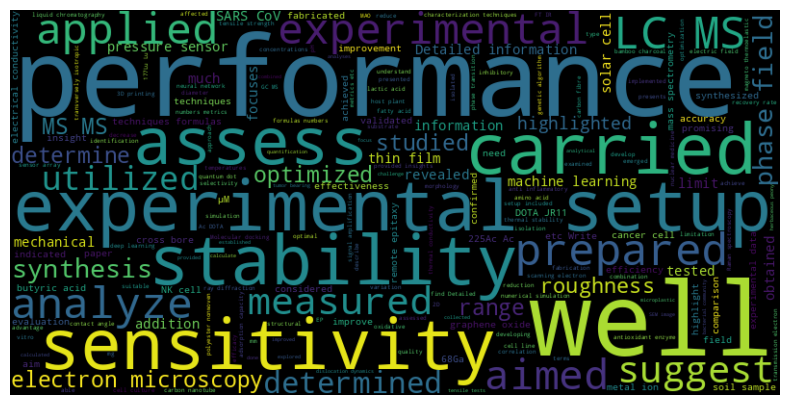

In [8]:
text = collect_text(data)
svg_output = generate_word_cloud(text)

# Make a method that can query the answer data and return how many questions were correct for a filter.

In [17]:
def check_correct_answers(first_data, second_data):
    correct_answers = 0
    for question_info in second_data:
        for question_id, question_data in question_info.items():
            if isinstance(question_data, dict) and 'Question' in question_data:
                correct_answer = question_data['Answer']
                question_prompt = question_data['Question']
                matching_entry = next((item for item in first_data if question_prompt in item['prompt']), None)
                if matching_entry and matching_entry['generated_answer'] == correct_answer:
                    correct_answers += 1

    return correct_answers

# Example usage

# ./GPT35_Answers/gpt3_5_evaluation_results.json
print("GPT-4")
print("-" * 10)
print("Filtered")
print("-" * 10)

correct_count_filtered = check_correct_answers(load_json("../results/GPT4_Answers/gpt4_evaluation_results.json"), filtered)
print(f'Number of correctly answered questions (filtered): {correct_count_filtered}')
print(f'Number of wrongly answered questions (filtered): {len(filtered) - correct_count_filtered}')
print(f'Accuracy (total): {correct_count_filtered / len(filtered):.2%}')

print("-" * 10)
print("Full Data")
print("-" * 10)

correct_count_total = check_correct_answers(load_json("../results/GPT4_Answers/gpt4_evaluation_results.json"), data)
print(f'Number of correctly answered questions (total): {correct_count_total}')
print(f'Number of wrongly answered questions (total): {len(data) - correct_count_total}')
print(f'Accuracy (total): {correct_count_total / len(data):.2%}')

print("=" * 50)
print("GPT-3.5")
print("-" * 10)
print("Filtered")
print("-" * 10)

correct_count_filtered = check_correct_answers(load_json("../results/GPT35_Answers/gpt3_5_evaluation_results.json"), filtered)
print(f'Number of correctly answered questions (filtered): {correct_count_filtered}')
print(f'Number of wrongly answered questions (filtered): {len(filtered) - correct_count_filtered}')
print(f'Accuracy (total): {correct_count_filtered / len(filtered):.2%}')

print("-" * 10)
print("Full Data")
print("-" * 10)

correct_count_total = check_correct_answers(load_json("../results/GPT35_Answers/gpt3_5_evaluation_results.json"), data)
print(f'Number of correctly answered questions (total): {correct_count_total}')
print(f'Number of wrongly answered questions (total): {len(data) - correct_count_total}')
print(f'Accuracy (total): {correct_count_total / len(data):.2%}')


GPT-4
----------
Filtered
----------
Number of correctly answered questions (filtered): 310
Number of wrongly answered questions (filtered): 40
Accuracy (total): 88.57%
----------
Full Data
----------
Number of correctly answered questions (total): 4000
Number of wrongly answered questions (total): 590
Accuracy (total): 87.15%
GPT-3.5
----------
Filtered
----------
Number of correctly answered questions (filtered): 288
Number of wrongly answered questions (filtered): 62
Accuracy (total): 82.29%
----------
Full Data
----------
Number of correctly answered questions (total): 3733
Number of wrongly answered questions (total): 857
Accuracy (total): 81.33%
